In [2]:
import numpy as np
from paus_utils import *
from astropy.table import Table
from load_paus_cat import paus_flux_units

from jpasLAEs.utils import mag_to_flux, flux_to_mag

from LAE_selection_method import *

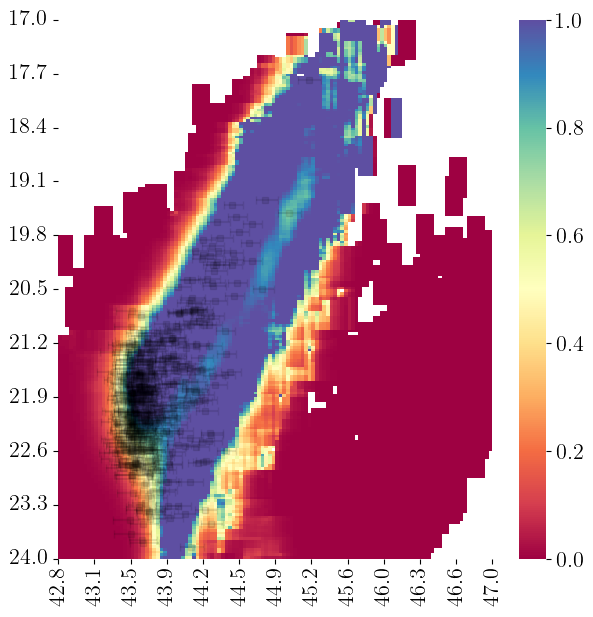

In [5]:
import seaborn as sns

region_name = 'W1'
nb1, nb2 = 0, 3

corr_dir = '/home/alberto/almacen/PAUS_data/LF_corrections'
r_bins = np.linspace(17, 24, 200 + 1)
L_bins = np.linspace(40, 47, 200 + 1)
puri2d = np.load(f'{corr_dir}/comp2D_{region_name}_nb{nb1}-{nb2}.npy')

import pickle

LF_name = f'Lya_LF_nb{nb1}-{nb2}_{region_name}'
pathname = f'/home/alberto/almacen/PAUS_data/Lya_LFs/{LF_name}'
with open(f'{pathname}/selection.pkl', 'rb') as f:
    selection = pickle.load(f)

def L_to_bins(L_Arr):
    return np.interp(L_Arr, L_bins, np.arange(len(L_bins)))
def r_to_bins(mag):
    return np.interp(mag, r_bins, np.arange(len(r_bins)))

fig, ax = plt.subplots(figsize=(7, 7))


selec_L = selection['L_lya_corr']
selec_L_err = selection['L_lya_corr_err']
L_Arr_b = L_to_bins(selec_L)
mag_b = r_to_bins(selection['r_mag'])
L_err_Arr_b = (L_to_bins(selec_L + selec_L_err)
                - L_to_bins(selec_L - selec_L_err)) * 0.5
ax.errorbar(L_Arr_b, mag_b, fmt='s', xerr=L_err_Arr_b,
        color='k', capsize=3, linestyle='', ms=4, alpha=0.1)

sns.heatmap(puri2d.T, vmin=0, vmax=1, ax=ax,
            cmap='Spectral', rasterized=True)

yticks = np.arange(len(r_bins))[::20]
ax.set_yticks(yticks)
ax.set_yticklabels(f'{s:0.1f}' for s in r_bins[yticks])

xticks = np.arange(len(L_bins))[::10]
ax.set_xticks(xticks)
ax.set_xticklabels([f'{s:0.1f}' for s in L_bins[xticks]])

ax.set(xlim=(80, 200), ylim=(200, 0))

plt.show()

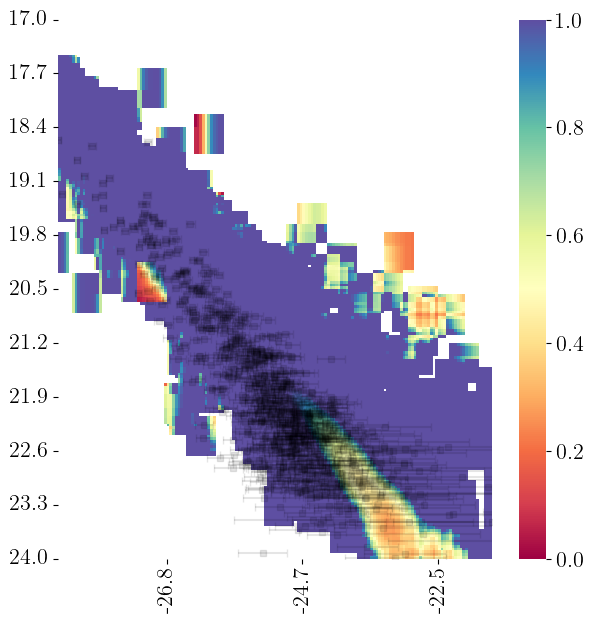

In [4]:
region_name = 'W1'
nb1, nb2 = 0, 3

corr_dir = '/home/alberto/almacen/PAUS_data/LF_corrections'
r_bins = np.load(f'{corr_dir}/puricomp2D_r_bins.npy')
L_bins = np.load(f'{corr_dir}/puricomp2D_M_UV_bins.npy')
puri2d = np.load(f'{corr_dir}/comp2D_{region_name}_nb{nb1}-{nb2}_UV.npy')

selection = pd.read_csv('/home/alberto/almacen/PAUS_data/catalogs/LAE_selection.csv')

def L_to_bins(L_Arr):
    return np.interp(L_Arr, L_bins, np.arange(len(L_bins)))
def r_to_bins(mag):
    return np.interp(mag, r_bins, np.arange(len(r_bins)))

fig, ax = plt.subplots(figsize=(7, 7))


selec_L = selection['M_UV']
selec_L_err = selection['M_UV_err']

L_Arr_b = L_to_bins(selec_L)
mag_b = r_to_bins(selection['r_mag'])
L_err_Arr_b = (L_to_bins(selec_L + selec_L_err)
                - L_to_bins(selec_L - selec_L_err)) * 0.5
ax.errorbar(L_Arr_b, mag_b, fmt='s', xerr=L_err_Arr_b,
        color='k', capsize=3, linestyle='', ms=4, alpha=0.1)

sns.heatmap(puri2d.T, vmin=0, vmax=1., ax=ax,
            cmap='Spectral', rasterized=True)

yticks = np.arange(len(r_bins))[::20]
ax.set_yticks(yticks)
ax.set_yticklabels(f'{s:0.1f}' for s in r_bins[yticks])

xticks = np.arange(len(L_bins))[::50]
ax.set_xticks(xticks)
ax.set_xticklabels([f'{s:0.1f}' for s in L_bins[xticks]])

ax.set(xlim=(10, 170), ylim=(200, 0))

plt.show()

In [ ]:
mask = selection['class_star'] > 0.
plt.scatter(selection['L_lya'][mask], selection['M_UV'][mask])

In [ ]:
# Load QSO mock
from load_paus_mocks import add_errors, load_qso_mock

source_cats_dir = '/home/alberto/almacen/Source_cats'
mock_path = f'{source_cats_dir}/QSO_PAUS_contaminants_2'
# mock_path = f'{source_cats_dir}/QSO_PAUS_LAES_hiL_2'
cat = load_qso_mock(mock_path)

field_name = 'W3'
cat['flx'], cat['err'] = add_errors(cat['flx_0'], field_name, True)

# Compute r_mag
cat['r_mag'] = flux_to_mag(cat['flx'][-4], w_central[-4])

N_sources = len(cat['r_mag'])
print(f'N_sources = {N_sources}')

mock = cat

In [ ]:
# # Load SFG mock
# from load_paus_mocks import add_errors, load_sfg_mock

# source_cats_dir = '/home/alberto/almacen/Source_cats'
# mock_SFG_path = f'{source_cats_dir}/LAE_12.5deg_z2.55-5_PAUS_0'
# cat = load_sfg_mock(mock_SFG_path)

# field_name = 'W3'
# cat['flx'], cat['err'] = add_errors(cat['flx_0'], field_name, True)

# # Compute r_mag
# cat['r_mag'] = flux_to_mag(cat['flx'][-4], w_central[-4])

# N_sources = len(cat['r_mag'])
# print(f'N_sources = {N_sources}')

# mock = cat

In [ ]:
# from load_paus_cat import load_paus_cat

# field_name = 'W3'
# path_to_cat = [f'/home/alberto/almacen/PAUS_data/catalogs/PAUS_3arcsec_{field_name}_extinction_corrected.pq']
# cat = load_paus_cat(path_to_cat)

# mask_NB_number = (cat['NB_number'] > 39)
# cat['flx'] = cat['flx'][:, mask_NB_number]
# cat['err'] = cat['err'][:, mask_NB_number]
# cat['NB_mask'] = cat['NB_mask'][:, mask_NB_number]
# for key in cat.keys():
#     if key in ['flx', 'err', 'NB_mask', 'area']:
#         continue
#     cat[key] = cat[key][mask_NB_number]

# stack_nb_ids = np.arange(12, 26 + 1)
# synth_BB_flx = np.average(cat['flx'][stack_nb_ids],
#                           weights=cat['err'][stack_nb_ids] ** -2,
#                           axis=0)
# cat['synth_r_mag'] = flux_to_mag(synth_BB_flx, w_central[-4])

# N_sources = len(cat['ref_id'])
# print(N_sources)

In [ ]:
# import matplotlib.colors as colors

# rows = np.arange(16)
# cols = [8, 16, 24, 32, 40]

# mask_NB_number = (cat['NB_number'] > 39)

# nfilter_mat = np.zeros((len(rows), len(cols)))
# for i, n_row in enumerate(rows):
#     for j, n_col in enumerate(cols):
#         fil_0 = n_row
#         fil_delta = np.min([39, fil_0 + n_col])

#         if fil_delta == 39 and fil_0 == 0:
#             extra_mask = mask_NB_number
#         else:
#             extra_mask = ~mask_NB_number

#         N_src = sum(np.all(np.isfinite(cat['flx'][fil_0 : fil_0 + fil_delta]),
#                            axis=0) & extra_mask)
#         nfilter_mat[i, j] = N_src

# fig, ax = plt.subplots(figsize=(8, 10))


# sns.heatmap(nfilter_mat, annot=True, ax=ax,
#             cbar=False, fmt='0.0f',
#             xticklabels=[f'+{c}' for c in cols],
#             yticklabels=rows,
#             norm=colors.LogNorm())

# ax.set_ylabel('First filter (f$_0$)')
# ax.set_xlabel('$\Delta f$')

# # fig.savefig('/home/alberto/Desktop/fil_table.pdf', facecolor='w')
# plt.show()

In [ ]:
from PAUS_Lya_LF_corrections import L_lya_bias_apply

nb_min, nb_max = 0, 39
r_min, r_max = 17, 24

print(f'Searching for LAEs at {z_NB(nb_min):0.2f} < z < {z_NB(nb_max):0.2f}')

cat = select_LAEs(cat, nb_min, nb_max, r_min, r_max, check_nice_z=True)
# cat = L_lya_bias_apply(cat, field_name, nb_min, nb_max)
cont_est, cont_err = estimate_continuum(cat['flx'], cat['err'],
                                        IGM_T_correct=True, N_nb=6)

In [ ]:
M, _ = PAUS_monochromatic_Mag(cat, flx_cat_key='flx_0', redshift_cat_key='zspec')
M_meas, _ = PAUS_monochromatic_Mag(cat, flx_cat_key='flx', redshift_cat_key='z_NB')

In [ ]:
plt.hist(M[cat['zspec'] < 2.7], np.linspace(-30, -20, 50), histtype='step')
plt.hist(M_meas[cat['zspec'] < 2.7], np.linspace(-30, -20, 50), histtype='step')
plt.show()

In [ ]:
from Make_Lya_LF import puricomp2d_weights
nb_min, nb_max = 0, 2
corr_dir = '/home/alberto/almacen/PAUS_data/LF_corrections'
puri2d = np.load(f'{corr_dir}/puri2D_{field_name}_nb{nb_min}-{nb_max}.npy')
comp2d = np.load(f'{corr_dir}/comp2D_{field_name}_nb{nb_min}-{nb_max}.npy')

puri2d_uv = np.load(f'{corr_dir}/puri2D_{field_name}_nb{nb_min}-{nb_max}.npy')
comp2d_uv = np.load(f'{corr_dir}/comp2D_{field_name}_nb{nb_min}-{nb_max}.npy')

puricomp2d_L_bins = np.load(f'{corr_dir}/puricomp2D_L_bins.npy')
puricomp2d_M_UV_bins = np.load(f'{corr_dir}/puricomp2D_M_UV_bins.npy')
puricomp2d_r_bins = np.load(f'{corr_dir}/puricomp2D_r_bins.npy')

M_UV_Arr, M_UV_err_Arr = PAUS_monochromatic_Mag(cat, wavelength=1450)
cat['M_UV'] = M_UV_Arr
cat['M_UV_err'] = M_UV_err_Arr

puri, comp = puricomp2d_weights(cat['r_mag'], cat['L_lya'], puri2d, comp2d,
                       puricomp2d_L_bins, puricomp2d_r_bins)
# puri_uv, comp_uv = puricomp2d_weights(cat['r_mag'], cat['M_UV'], puri2d_uv, comp2d_uv,
#                        puricomp2d_M_UV_bins, puricomp2d_r_bins)

In [ ]:
# nb_list = [[0, 2], [2, 4], [4, 6], [6, 8],
#         [8, 10], [10, 12], [12, 14], [14, 16], [16, 18]]

# for nb_min, nb_max in nb_list:
#     print(f'\nnbs: {nb_min}-{nb_max}')
#     # Study color distributions
#     import pickle
#     from load_paus_mocks import load_mock_dict

#     field_name = 'W3'
#     savedir = '/home/alberto/almacen/PAUS_data/LF_corrections'

#     # nb_min, nb_max = 4, 6

#     color_dict = {
#         'SFG': 'C1',
#         'QSO_cont': 'dimgray',
#         'QSO_LAEs_loL': 'C0',
#         'QSO_LAEs_hiL': 'blue',
#         'GAL': 'C2'
#     }

#     with open(f'{savedir}/mock_dict_{field_name}_nb{nb_min}-{nb_max}.pkl', 'rb') as f:
#         mock_dict = pickle.load(f)

#     # source_cats_dir = '/home/alberto/almacen/Source_cats'
#     # mock_SFG_path = f'{source_cats_dir}/LAE_12.5deg_z2.55-5_PAUS_0'
#     # mock_QSO_cont_path = f'{source_cats_dir}/QSO_PAUS_contaminants_2'
#     # mock_QSO_LAEs_loL_path = f'{source_cats_dir}/QSO_PAUS_LAES_2'
#     # mock_QSO_LAEs_hiL_path = f'{source_cats_dir}/QSO_PAUS_LAES_hiL_2'
#     # mock_GAL_path = '/home/alberto/almacen/PAUS_data/catalogs/LightCone_mock.fits'
#     # mock_dict = load_mock_dict(mock_SFG_path, mock_QSO_cont_path,
#     #                                 mock_QSO_LAEs_loL_path, mock_QSO_LAEs_hiL_path,
#     #                                 mock_GAL_path, gal_fraction=0.3)

#     m_color_bins = np.linspace(-2, 2, 30)

#     # color_name = ['ug', 'gr', 'ri', 'iz'][::-1]
#     color_name = ['ug', 'gr'][::-1]

#     for i, cname in enumerate(color_name):
#         fig, ax = plt.subplots(figsize=(6, 4))

#         for mock_name, mock in mock_dict.items():
#             nice_lya = mock['nice_lya_0'] & (np.abs(mock['zspec'] - z_NB(mock['lya_NB'])) < 0.2)
#             m_color = (flux_to_mag(mock['flx'][-3 - i][nice_lya], w_central[-3 - i])
#                     - flux_to_mag(mock['flx'][-2 - i][nice_lya], w_central[-2 - i]))

#             ax.hist(m_color, m_color_bins,
#                     color=color_dict[mock_name],
#                     histtype='step', density=True,
#                     lw=2)

#             if mock_name == 'QSO_LAEs_hiL':
#                 perc = np.nanpercentile(m_color, [1, 99])
#                 print(f'{cname} = {perc}')
#                 for p in perc:
#                     ax.axvline(p, ls='--', color='k')

#             ax.set_title(cname)
#             # ax.set_yscale('log')

#         plt.show()

In [ ]:
# sdss_xm = pd.read_csv(f'/home/alberto/almacen/PAUS_data/catalogs/Xmatch_SDSS_{field_name}.csv')

In [ ]:
qso_lines = [1025.7220, 1397.61, 1549.48, 1908.73, 2799.12, 2326, 3727, 912]
qso_lines_name = ['LyB', 'SiIV', 'CIV', 'CIII', 'MgII', 'CII', 'OII', r'Ly$\infty$']

line_dict = {'halpha': 6564.61,
             'hbeta': 4862.68,
             'oii3727': 3727.10,
             'oiii4959': 4960.30,
             'oiii5007': 5008.24}

nice_lya = cat['nice_lya']
z_Arr = cat['z_NB']
lya_lines = cat['lya_NB']
other_lines = cat['other_lines_NBs']

for name, w in zip(qso_lines_name, qso_lines):
    line_dict[name] = w

selection = (
    # (cat['NB_number'] > 39)
    cat['nice_lya']
    # & cat['nice_color']
    # & cat['nice_ml']
    # & (cat['class_pred'] == 2)
    # & (z_NB(nb_min) <= cat['zspec']) & (z_NB(nb_max) >= cat['zspec'])
    # & cat['nice_z']
    # & (np.abs(cat['z_NB'] - sdss_xm['z_best']) > 0.2)
    & (lya_lines >= 0)
    & (lya_lines <= 3)
    & (cat['M_UV'] < -20)
    # & (cat['synth_r_mag'] > 17)
    & (cat['L_lya'] < 44)
    # & (cat['DEC'] > 53.4) & (cat['DEC'] < 53.7)
    # & (cat['RA'] > 211) & (cat['RA'] < 212)

)

print(f'{sum(selection)=}')

ug = flux_to_mag(cat['flx'][-6], w_central[-6]) - flux_to_mag(cat['flx'][-5], w_central[-5])


for i, src in enumerate(np.random.permutation(np.where(selection)[0])):
    if i == 10:
        break

    print(f'r = {cat["r_mag"][src]:0.2f}, L_lya = {cat["L_lya"][src]:0.2f}, ',
          f'EW0_Lya = {cat["EW0_lya"][src]:0.2f}, '
          f'\nclass_pred = {cat["class_pred"][src]}'
          f'\nM_UV = {cat["M_UV"][src]:0.2f} +/- {cat["M_UV_err"][src]:0.2f}'
          f'\nnice_lya={cat["nice_lya"][src]}, nice_color={cat["nice_color"][src]}, nice_lines={cat["nice_ml"][src]}'
          f'\nz_NB = {z_Arr[src]:0.2f}, ',
        #   f'\nclass_star = {cat["class_star"][src]:0.2f}',
        #   f'\nzspec = {np.array(cat["zspec"])[src]:0.2f}',
        #   f'\nL_lya_spec = {np.array(sdss_xm["L_lya"])[mask_NB_number][src]:0.2f}',
        #   f'\nEW0_lya_spec = {np.array(sdss_xm["EW0_lya"])[mask_NB_number][src]:0.2f}',
          f'\npuri = {puri[src]:0.2f}, comp = {comp[src]:0.2f} ({puri[src]/comp[src]:0.2f})',
        #   f'\npuri_uv = {puri_uv[src]:0.2f}, comp_uv = {comp_uv[src]:0.2f} ({puri_uv[src]/comp_uv[src]:0.2f})',
          f'\nS/N(u) = {cat['flx'][-6][src] / cat['err'][-6][src]:0.1f}',
          f'\nS/N(g) = {cat['flx'][-5][src] / cat['err'][-5][src]:0.1f}',
          f'ug = {ug[src]:0.2f}')


    fig, ax = plt.subplots(figsize=(8, 5))

    cat['flx'][-1, src] = 0
    cat['err'][-1, src] = 0
    plot_PAUS_source(cat['flx'][:, src], cat['err'][:, src],
                     ax=ax, plot_BBs=True, set_ylim=True)

    # fits_dir = '/home/alberto/almacen/SDSS_spectra_fits/DR16/QSO'
    # plate = np.array(sdss_xm['plate'])[mask_NB_number][src]
    # mjd = np.array(sdss_xm['mjd'])[mask_NB_number][src]
    # fiber = np.array(sdss_xm['fiberid'])[mask_NB_number][src]
    # spec_name = f'spec-{plate:04d}-{mjd:05d}-{fiber:04d}.fits'
    # print(spec_name)
    # spec_bool = True
    # try:
    #     spec_sdss = Table.read(f'{fits_dir}/{spec_name}', hdu=1, format='fits')
    #     sdss_bbs = Table.read(f'{fits_dir}/{spec_name}', hdu=2, format='fits')['SPECTROFLUX']
    #     r_band_sdss = nanomaggie_to_flux(np.array(sdss_bbs)[0][2], 6250)
    # except:
    #     print('Couldn\'t load the SDSS spectrum.')
    #     spec_bool = False

    # if spec_bool:
    #     # Normalizing factor:
    #     norm = synth_BB_flx[src] / r_band_sdss
    #     spec_flx_sdss = spec_sdss['FLUX'] * norm
    #     spec_w_sdss = 10 ** spec_sdss['LOGLAM']

    #     rebin_factor = 2
    #     spec_flx_sdss_rb, _ = rebin_1d_arr(spec_flx_sdss,
    #                                         spec_w_sdss,
    #                                         rebin_factor)

    #     spec_w_sdss_rb = np.empty_like(spec_flx_sdss_rb)
    #     for i in range(len(spec_flx_sdss_rb)):
    #         spec_w_sdss_rb[i] = spec_w_sdss[i * rebin_factor]

    #     ax.plot(spec_w_sdss_rb, spec_flx_sdss_rb,
    #             c='dimgray', zorder=-99, alpha=0.7)

    ax.errorbar(w_central[:35], cont_est[:35, src] * 1e17,
                yerr=cont_err[:35, src] * 1e17)

    ax.axvline(w_central[lya_lines[src]], ls='--', c='r')

    nb_w_rest = NB_z(cat['z_NB'][src], 1450)
    # nb_min = np.max([nb_w_rest - 2, 0])
    # nb_max = nb_w_rest + 1
    # for nb in range(nb_min, nb_max + 1):
    #     ax.axvline(w_central[nb])
    ax.axvline(w_central[nb_w_rest])

    # nb_w_rest = NB_z(cat['zspec'][src], 1450)
    # nb_min = np.max([nb_w_rest - 2, 0])
    # nb_max = nb_w_rest + 1
    # for nb in range(nb_min, nb_max + 1):
    #     ax.axvline(w_central[nb], c='C1')

    for name, w in zip(qso_lines_name, qso_lines):
        qso_obs_w = w * (1 + z_Arr[src])
        if (4000 > qso_obs_w) | (qso_obs_w > 8600):
            continue
        ax.axvline(qso_obs_w, linestyle=':', color='orange')
        ypos = cat['flx'][:40, src].min() * 1e17
        ax.text(qso_obs_w, ypos, name, color='k')
    
    plt.show()